<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/preprocess_data_theo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# I. Load data

## a) read_csv

In [ ]:
url = 'https://drive.google.com/file/d/14rWJ6OKc_aZbAcb6h220vQP0xfitLgHM/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, sep=";")

# df = pd.read_csv("energy_use_in_the_UK.csv", sep=";")

print(df.shape)
display(df.head())
display(df.info())

(796453, 6)


,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01 00:00:01,8693,7121,2740,728,0.0
1,2012-01-01 00:05:06,8650,7120,2812,732,0.0
2,2012-01-01 00:10:01,8880,7125,2896,744,0.0
3,2012-01-01 00:15:01,9111,7122,2964,748,0.0
4,2012-01-01 00:20:01,9195,7114,2992,750,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796453 entries, 0 to 796452
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0    timestamp  796453 non-null  object 
 1    coal       796453 non-null  int64  
 2    nuclear    796453 non-null  int64  
 3    wind       796453 non-null  int64  
 4    hydro      796453 non-null  int64  
 5    solar      796453 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 36.5+ MB


None

## b) remove space in cols, timestamp to datetime

In [ ]:
if df.columns[0][0] == " ":
  df = df.rename(columns=lambda x: x[1:])
df["timestamp"] = pd.to_datetime(df["timestamp"])

## c) plot values

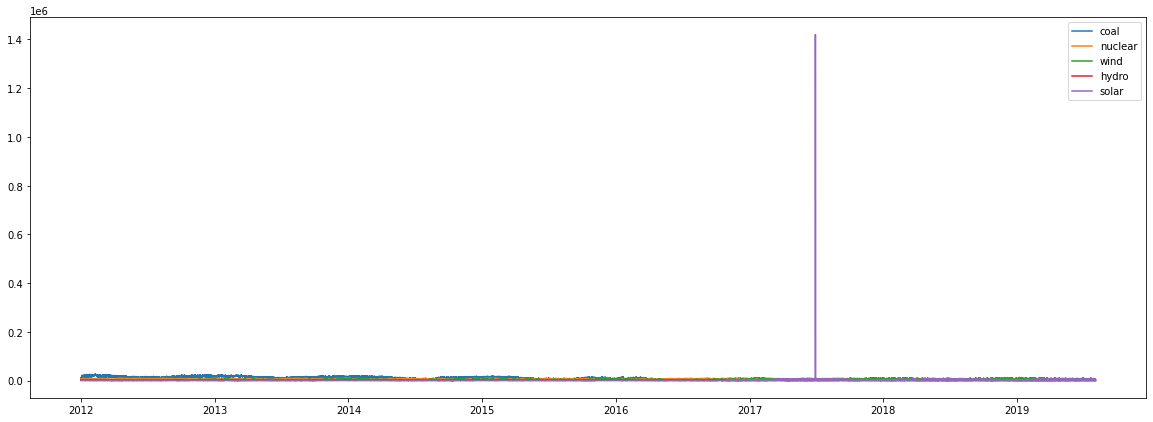

In [ ]:
plt.figure(figsize=(20,7))
for col in df.columns[1:]:
    plt.plot(df["timestamp"], df[col], label=col)
plt.legend()
plt.show()

## d) remove solar outlayers

In [ ]:
print(df["solar"].max())
idx = np.argmax(df["solar"])
print(idx)

1420000.0
576229


In [ ]:
display(df.iloc[idx-2:idx+3])
df["solar"][576229] = np.nan
df["solar"][576230] = np.nan
df["solar"] = df["solar"].interpolate()
display(df.iloc[idx-2:idx+3])

,timestamp,coal,nuclear,wind,hydro,solar
576227,2017-06-29 15:25:32,1572,7946,4584,367,1570.0
576228,2017-06-29 15:30:31,1572,7946,4584,367,1570.0
576229,2017-06-29 15:35:32,1572,7946,4584,367,1420000.0
576230,2017-06-29 15:40:33,1572,7946,4584,367,1420000.0
576231,2017-06-29 15:45:33,1572,7946,4584,367,1450.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,coal,nuclear,wind,hydro,solar
576227,2017-06-29 15:25:32,1572,7946,4584,367,1570.0
576228,2017-06-29 15:30:31,1572,7946,4584,367,1570.0
576229,2017-06-29 15:35:32,1572,7946,4584,367,1530.0
576230,2017-06-29 15:40:33,1572,7946,4584,367,1490.0
576231,2017-06-29 15:45:33,1572,7946,4584,367,1450.0


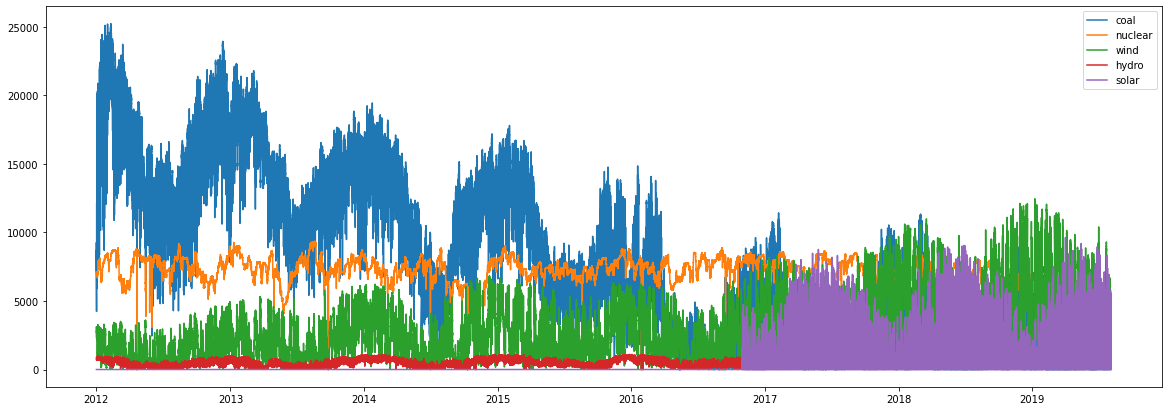

In [ ]:
plt.figure(figsize=(20,7))
for col in df.columns[1:]:
    plt.plot(df["timestamp"], df[col], label=col)
plt.legend()
plt.show()

## g) groupby hour dataframe (mean)

show value_counts by hour

In [ ]:
tmp = df.copy()

tmp = tmp.drop_duplicates().reset_index(drop=True)

date_col = "timestamp"

# hour
tmp[date_col] = tmp[date_col].map(lambda x: datetime(x.year, x.month, x.day, x.hour, 0, 0))

ret = tmp.groupby([date_col], axis=0, as_index=False).count()
print(ret['coal'].value_counts())

12    66064
11      155
10       67
13       33
9        29
8        24
7        14
6        13
3         9
1         8
4         7
5         5
2         4
14        3
19        1
15        1
16        1
22        1
Name: coal, dtype: int64


As we don't have same numbers of values for each hour, we can't sum this values  
We're gonna calculate the mean of each value per hour

shape: (66439, 6)


,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01 00:00:00,107545.0,84685.0,35915.0,8971.0,0.0
1,2012-01-01 01:00:00,103154.0,83313.0,35674.0,9108.0,0.0
2,2012-01-01 02:00:00,92415.0,83339.0,35211.0,8977.0,0.0
3,2012-01-01 03:00:00,74389.0,83337.0,35654.0,8952.0,0.0
4,2012-01-01 04:00:00,64333.0,84255.0,36024.0,8940.0,0.0


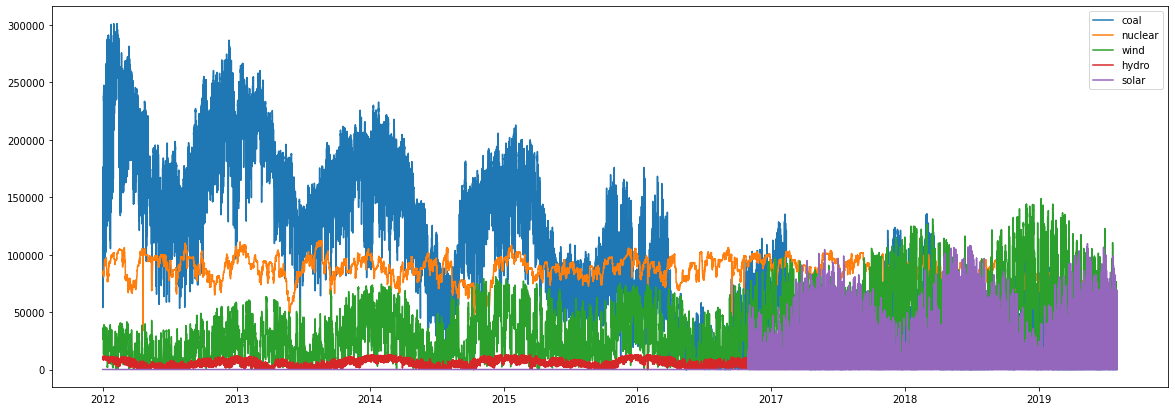

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

df["timestamp"] = df["timestamp"].map(lambda x: datetime(x.year, x.month, x.day, x.hour, 0, 0))

df = df.groupby([date_col], axis=0, as_index=False).mean()
df["coal"] = df["coal"] * 12
df["nuclear"] = df["nuclear"] * 12
df["wind"] = df["wind"] * 12
df["hydro"] = df["hydro"] * 12
df["solar"] = df["solar"] * 12

print("shape:", df.shape)
display(df.head())

plt.figure(figsize=(20,7))
for col in df.columns[1:]:
    plt.plot(df["timestamp"], df[col], label=col)
plt.legend()
plt.show()

find missing hours

In [ ]:
tmp = df.copy()

tmp["timestamp"] = tmp["timestamp"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0, 0))
# 2012-01-01

ret = tmp.groupby([date_col], axis=0, as_index=False).count()
print("nb days with x values:")
print(ret['coal'].value_counts())

first_date = df["timestamp"][0]
last_date = df["timestamp"][df.shape[0] - 1]
print("nb days expected:", (last_date - first_date).days + 1)
print("nb days actual:", ret.shape[0])

nb days with x values:
24    2752
23       5
21       5
16       4
14       2
19       1
22       1
20       1
18       1
Name: coal, dtype: int64
nb days expected: 2772
nb days actual: 2772


In [ ]:
# dates = missing hours
dates = ret[ret["coal"] != 24]["timestamp"].values
dates

array(['2012-11-28T00:00:00.000000000', '2013-02-02T00:00:00.000000000',
       '2013-04-03T00:00:00.000000000', '2013-07-13T00:00:00.000000000',
       '2013-07-14T00:00:00.000000000', '2014-03-26T00:00:00.000000000',
       '2014-07-25T00:00:00.000000000', '2014-11-19T00:00:00.000000000',
       '2014-12-08T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2016-09-13T00:00:00.000000000', '2016-09-26T00:00:00.000000000',
       '2017-01-21T00:00:00.000000000', '2018-03-06T00:00:00.000000000',
       '2018-11-22T00:00:00.000000000', '2019-08-03T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
df["timestamp_day"] = df["timestamp"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0, 0))
df["original_data"] = True

In [ ]:
# append NaN row for each missing date

data = {
  "timestamp": []
}

for date in dates:
  date = pd.to_datetime(date)
  tmp = df[df["timestamp_day"] == date]
  # display(tmp)
  for hour in range(0, 24):
    if not np.any(tmp["timestamp"].dt.hour == hour):
      data["timestamp"].append(datetime(date.year, date.month, date.day, hour, 0, 0))
      # print(hour)


data["original_data"] = False

df = df.append(pd.DataFrame(data=data))
df = df.sort_values(by="timestamp" ).reset_index(drop=True)

display(df)

,timestamp,coal,nuclear,wind,hydro,solar,timestamp_day,original_data
0,2012-01-01 00:00:00,107545.0,84685.0,35915.0,8971.0,0.0,2012-01-01,True
1,2012-01-01 01:00:00,103154.0,83313.0,35674.0,9108.0,0.0,2012-01-01,True
2,2012-01-01 02:00:00,92415.0,83339.0,35211.0,8977.0,0.0,2012-01-01,True
3,2012-01-01 03:00:00,74389.0,83337.0,35654.0,8952.0,0.0,2012-01-01,True
4,2012-01-01 04:00:00,64333.0,84255.0,36024.0,8940.0,0.0,2012-01-01,True
...,...,...,...,...,...,...,...,...
66523,2019-08-03 19:00:00,0.0,66247.0,8012.0,5001.0,3632.0,2019-08-03,True
66524,2019-08-03 20:00:00,0.0,64568.0,8320.0,4672.0,600.0,2019-08-03,True
66525,2019-08-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaT,False
66526,2019-08-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaT,False


In [ ]:
# check if we have 24 values / day

tmp = df.copy()
tmp = tmp.fillna(-1)
display(tmp.tail())

date_col = "timestamp"


tmp["timestamp"] = tmp["timestamp"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0, 0))

ret = tmp.groupby([date_col], axis=0, as_index=False).count()
print("nb days with x values:")
print(ret['coal'].value_counts())

first_date = df["timestamp"][0]
last_date = df["timestamp"][df.shape[0] - 1]
print("nb days expected:", (last_date - first_date).days + 1)
print("nb days actual:", ret.shape[0])

,timestamp,coal,nuclear,wind,hydro,solar,timestamp_day,original_data
66523,2019-08-03 19:00:00,0.0,66247.0,8012.0,5001.0,3632.0,2019-08-03 00:00:00,True
66524,2019-08-03 20:00:00,0.0,64568.0,8320.0,4672.0,600.0,2019-08-03 00:00:00,True
66525,2019-08-03 21:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1,False
66526,2019-08-03 22:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1,False
66527,2019-08-03 23:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1,False


nb days with x values:
24    2772
Name: coal, dtype: int64
nb days expected: 2772
nb days actual: 2772


In [ ]:
# interpolate (fill) new rows
for col in df.columns[1:-2]:
  print(col)
  df[col] = df[col].interpolate()

coal
nuclear
wind
hydro
solar


In [ ]:
df.drop("timestamp_day", axis=1, inplace=True)

,timestamp,coal,nuclear,wind,hydro,solar,original_data
0,2012-01-01 00:00:00,107545.0,84685.0,35915.0,8971.0,0.0,True
1,2012-01-01 01:00:00,103154.0,83313.0,35674.0,9108.0,0.0,True
2,2012-01-01 02:00:00,92415.0,83339.0,35211.0,8977.0,0.0,True
3,2012-01-01 03:00:00,74389.0,83337.0,35654.0,8952.0,0.0,True
4,2012-01-01 04:00:00,64333.0,84255.0,36024.0,8940.0,0.0,True
...,...,...,...,...,...,...,...
66523,2019-08-03 19:00:00,0.0,66247.0,8012.0,5001.0,3632.0,True
66524,2019-08-03 20:00:00,0.0,64568.0,8320.0,4672.0,600.0,True
66525,2019-08-03 21:00:00,0.0,64568.0,8320.0,4672.0,600.0,False
66526,2019-08-03 22:00:00,0.0,64568.0,8320.0,4672.0,600.0,False


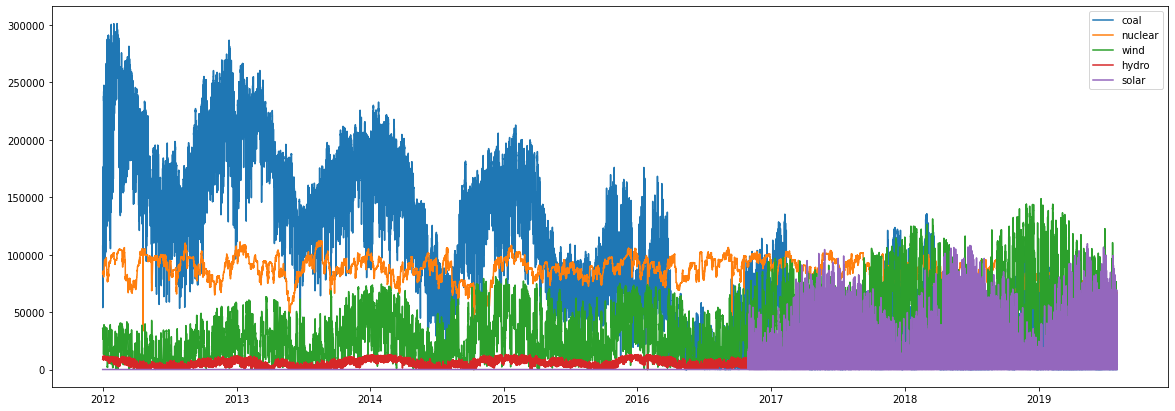

In [ ]:
display(df)
plt.figure(figsize=(20,7))
for col in df.columns[1:-1]:
    plt.plot(df["timestamp"], df[col], label=col)
plt.legend()
plt.show()

In [ ]:
df.to_csv("mean_energy_use_by_hour.csv", index=False)

## i) groupby day dataframe (mean)

shape: (2772, 7)


,timestamp,coal,nuclear,wind,hydro,solar,original_data
0,2012-01-01,2.448325e+06,2.029537e+06,760388.000000,226484.000000,0.0,1.0
1,2012-01-02,2.943019e+06,2.037875e+06,795772.727273,224168.363636,0.0,1.0
2,2012-01-03,4.430877e+06,2.005847e+06,621916.000000,231623.000000,0.0,1.0
3,2012-01-04,4.903744e+06,2.039013e+06,764407.000000,232221.000000,0.0,1.0
4,2012-01-05,4.765032e+06,2.171748e+06,760181.000000,238301.000000,0.0,1.0


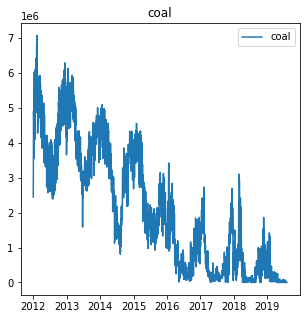

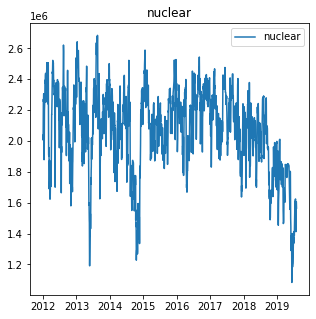

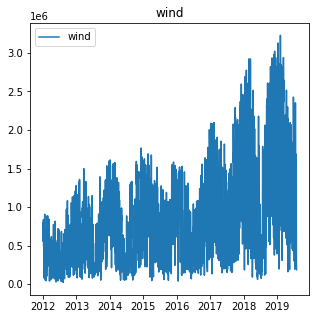

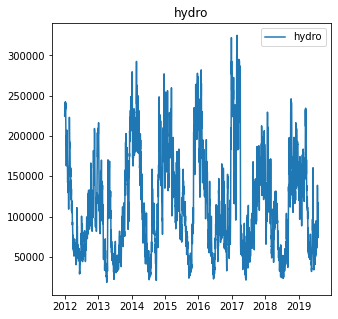

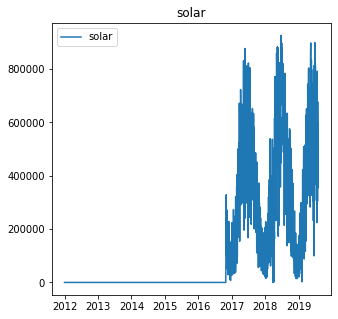

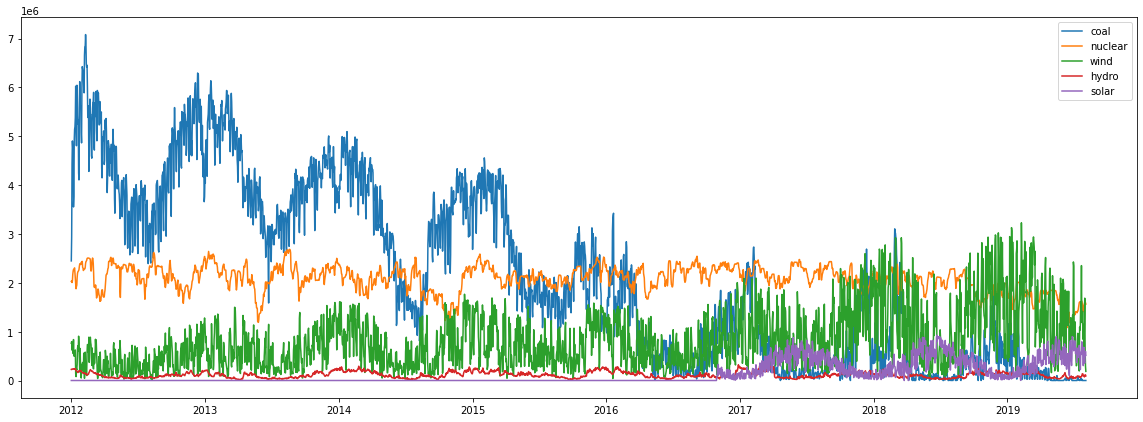

In [ ]:
df["timestamp"] = df["timestamp"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0, 0))

df = df.groupby([date_col], axis=0, as_index=False).mean()
df["coal"] = df["coal"] * 24
df["nuclear"] = df["nuclear"] * 24
df["wind"] = df["wind"] * 24
df["hydro"] = df["hydro"] * 24
df["solar"] = df["solar"] * 24

print("shape:", df.shape)
display(df.head())

for col in df.columns[1:-1]:
  plt.figure(figsize=(5,5))
  plt.title(col)
  plt.plot(df["timestamp"], df[col], label=col)
  plt.legend()
  plt.show()
  
plt.figure(figsize=(20,7))
for col in df.columns[1:-1]:
    plt.plot(df["timestamp"], df[col], label=col)
plt.legend()
plt.show()

In [ ]:
df.to_csv("mean_energy_use_by_day.csv", index=False)

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# II. Pred II le retour

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from tqdm.keras import TqdmCallback

import os
from tqdm import tqdm

In [ ]:
col = "nuclear"

df = pd.read_csv("mean_energy_use_by_day.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
print(df.shape)
display(df.head())
df.info()

(2772, 7)


,timestamp,coal,nuclear,wind,hydro,solar,original_data
0,2012-01-01,2.448325e+06,2.029537e+06,760388.000000,226484.000000,0.0,1.0
1,2012-01-02,2.943019e+06,2.037875e+06,795772.727273,224168.363636,0.0,1.0
2,2012-01-03,4.430877e+06,2.005847e+06,621916.000000,231623.000000,0.0,1.0
3,2012-01-04,4.903744e+06,2.039013e+06,764407.000000,232221.000000,0.0,1.0
4,2012-01-05,4.765032e+06,2.171748e+06,760181.000000,238301.000000,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      2772 non-null   datetime64[ns]
 1   coal           2772 non-null   float64       
 2   nuclear        2772 non-null   float64       
 3   wind           2772 non-null   float64       
 4   hydro          2772 non-null   float64       
 5   solar          2772 non-null   float64       
 6   original_data  2772 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 151.7 KB


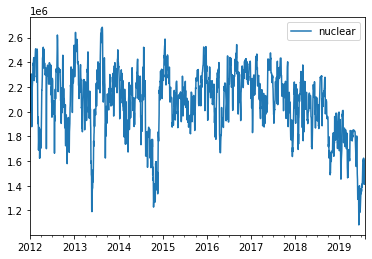

,nuclear
2012-01-01,2.029537e+06
2012-01-02,2.037875e+06
2012-01-03,2.005847e+06
2012-01-04,2.039013e+06
2012-01-05,2.171748e+06


In [ ]:
df = df[["timestamp", col]]
df.set_index(df["timestamp"].values, drop=True, inplace=True)
df.drop("timestamp", axis=1, inplace=True)
df.plot()
plt.show()
df.head()

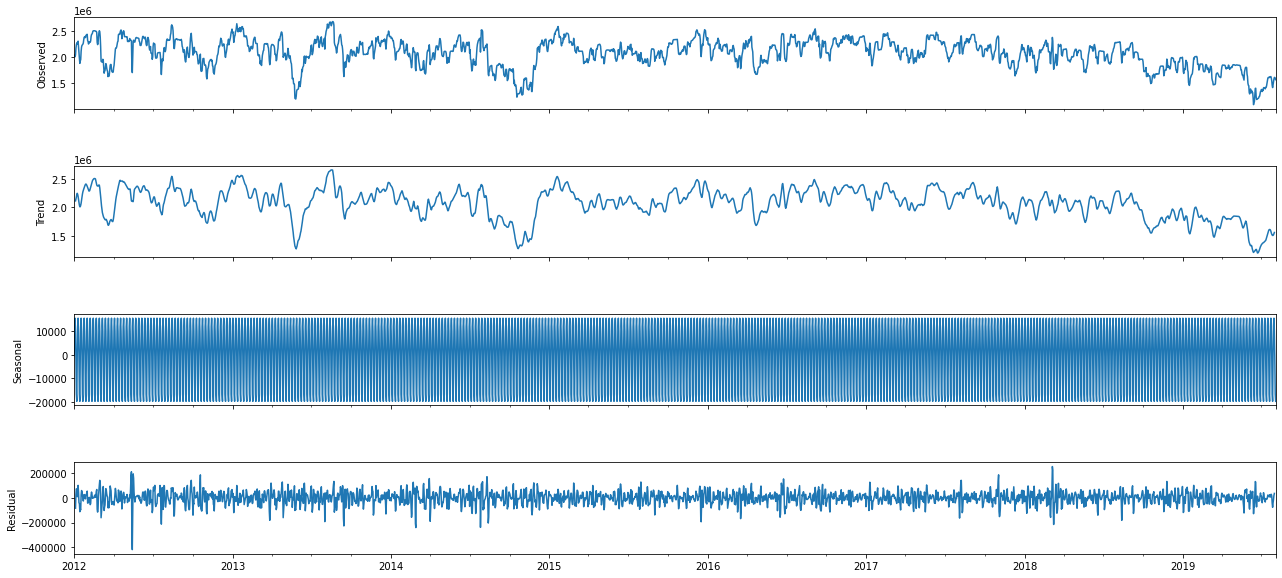

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df)
fig = decomposition.plot();
fig.set_size_inches(21, 9)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


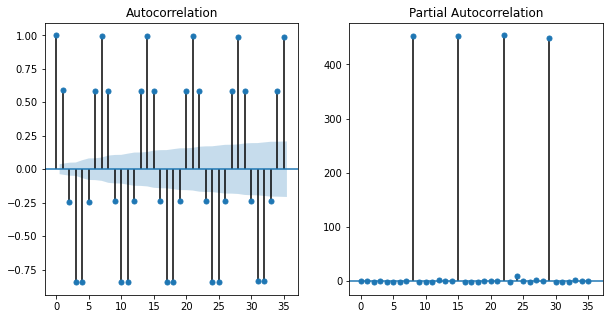

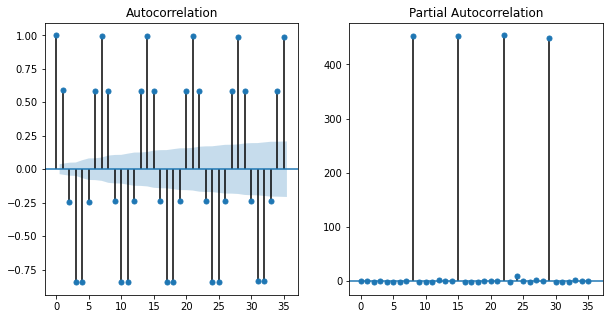

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plot_acf(decomposition.seasonal, ax=ax[0])
plot_pacf(decomposition.seasonal, ax=ax[1])

In [ ]:
# Divide data into train and test sets
train_split_percent = 0.80

train_split_percent = int(df.shape[0] * train_split_percent)

train = df.iloc[:train_split_percent]
test = df.iloc[train_split_percent:]

In [ ]:
# Normalize training data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
 
# Create supervised data with 12 inputs and 1 output
n_lag = 30
X_train = []
y_train = []
for i in range(n_lag, len(train) - n_lag):
    X_train.append(train_scaled[i-n_lag:i, 0])
    y_train.append(train_scaled[i:i+n_lag, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Reshape train set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# model = Sequential()
# # model.add(LSTM(units=n_lag, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True, dropout=0.2))
# model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1), return_sequences=True, dropout=0.2))
# model.add(LSTM(units=100, input_shape=(X_train.shape[1], 1)))
# model.add(Dense(units=1))
# opt = RMSprop(learning_rate=0.0001)
# model.compile(optimizer = opt, loss = 'mae')
# # # model.compile(optimizer="adam", loss="mse")
# # model.compile(optimizer="adam", loss="mae")
 
# # Fit LSTM to the training set with a split for validation
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32)

inputs = Input(shape=(X_train.shape[1], 1))

main = Dense(n_lag, activation="relu")(inputs)
# main = LSTM(256, activation="relu", return_sequences=True)(main)
# main = LSTM(128, activation="relu", return_sequences=True)(main)
# main = LSTM(64, activation="relu")(main)

# main = LSTM(2048, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(1024, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(512, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)
# main = Dense(64, activation="relu")(main)
main = Dense(n_lag, activation=None, name='output')(main)

model = Model(inputs, main)

model.summary()
plot_model(model, to_file="blbl.png", show_shapes=True)

model.compile(
  optimizer = Adam(learning_rate=0.001),
  # optimizer = RMSprop(learning_rate=0.001),
  loss = "mse",
)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 60)            120       
_________________________________________________________________
lstm_17 (LSTM)               (None, 60, 256)           324608    
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 256)           525312    
_________________________________________________________________
lstm_19 (LSTM)               (None, 60, 128)           197120    
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 60)                3900

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

  0%|          | 0.00/105 [00:00<?, ?batch/s]

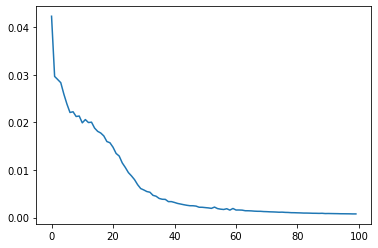

In [ ]:
if not os.path.isdir("model"):
  os.system("mkdir model")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model/model.h5",
    mode='max',
    save_best_only=True)

history = model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      epochs=100,
      verbose=0,
      batch_size=16,
      callbacks=[model_checkpoint_callback, TqdmCallback(verbose=2), EarlyStopping(monitor='loss', patience=10)]
  )

# show loss
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.show()

In [ ]:
# model = 

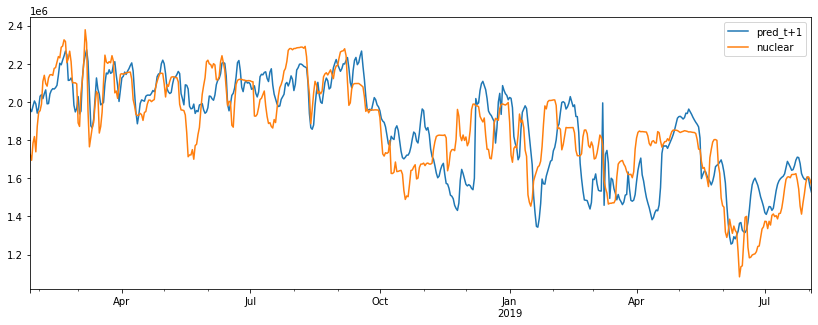

In [ ]:
inputs = df[len(df) - len(test) - n_lag:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(n_lag, n_lag+len(test)):
    X_test.append(inputs[i-n_lag:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 
# Forecast
predict_scaled = model.predict(X_test)
pred_tab = []
for tmp in predict_scaled:
  pred_tab.append(tmp[0])
predict = sc.inverse_transform(np.reshape(pred_tab, (-1, 1)))

# predict_scaled = regressor.predict(X_test)
# predict = sc.inverse_transform(predict_scaled)

predict = pd.DataFrame(predict)
predict.columns = ['pred_t+1']
predict.index = test.index
predict[col] = test.values

predict.plot(figsize=(14,5))



  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 16.13it/s]

 40%|████      | 4/10 [00:00<00:00, 15.55it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.66it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.92it/s]

100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


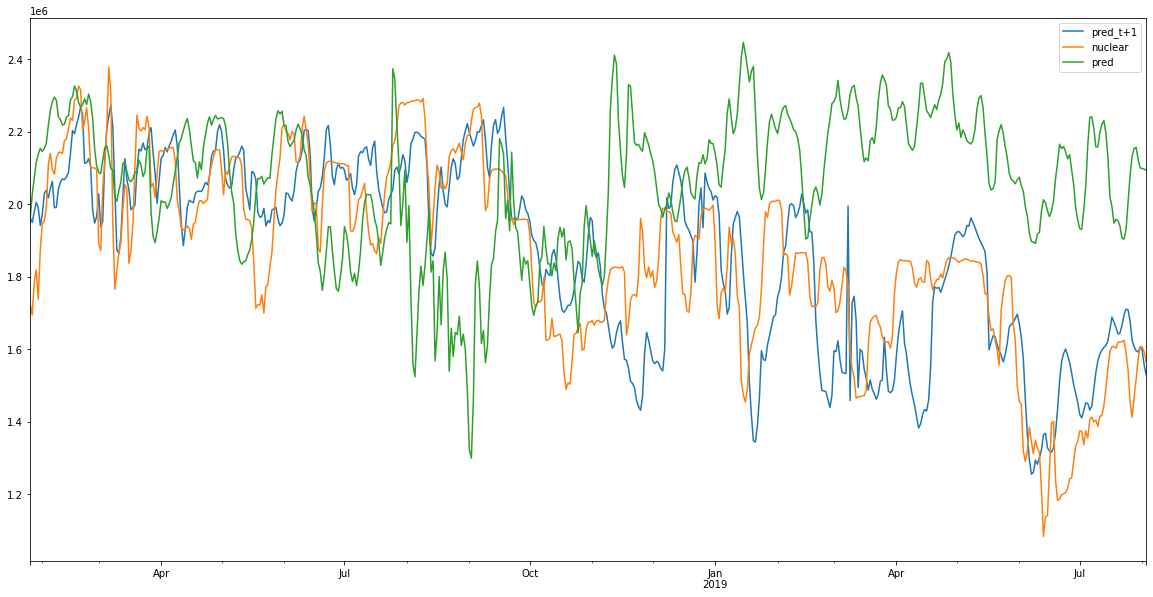

In [ ]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))


for index in tqdm(range(0, len(test), n_lag)):

  current_prediction = model.predict(current_batch)[0]

  test_predictions += list(current_prediction)

  current_batch = current_prediction.reshape((1, n_lag, 1))
  

# for index in tqdm(range(0, len(test))):

#   current_prediction = model.predict(current_batch)[0][0]

#   test_predictions.append(current_prediction)

#   current_batch = np.append(current_batch[:, 1:, :], [[[current_prediction]]], axis=1)


test_predictions_unnormalized = sc.inverse_transform(np.reshape(test_predictions, (-1, 1)))

predict["pred"] = test_predictions_unnormalized[:predict.shape[0]]
predict.plot(figsize=(20,10))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(predict[col], predict["pred"]))
print(rmse)

398755.2791647255
